# SentencePiece를 활용한 영화리뷰 감정분석

이번 프로젝트에서는 구글의 SentencePiece을 활용해 토크나이징을 진행해보고 이를 이전 Exploration6에서 진행했던 [네이버 영화리뷰 감정분석](https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp06/Exp06_Assignment_MovieReview.ipynb)에 적용해보겠다.



In [ ]:
!pip install konlpy   

In [ ]:
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
!pip install sentencepiece

In [4]:
!tar -xzvf '/content/drive/MyDrive/Colab Notebooks/Aiffel/03_GoingDeeper/02/data/korean-english-park.train.tar.gz'

korean-english-park.train.en
korean-english-park.train.ko


In [9]:
import tensorflow as tf
import numpy as np
import konlpy
import sentencepiece
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)
print(np.__version__)
print(konlpy.__version__)

2.8.0
1.21.5
0.6.0


# SentencePiece의 활용
---
- 서브워드 토큰화를 위한 BPE(Byte Pair Encoding) 알고리즘과 Unigram Language Model Tokenizer를 구현한 오픈 라이브러리

### corpus 구성
LMS에서 정제했던 corpus를 사용하기위한 설정을 해주겠다.

In [6]:
def read_rawfile(path):
    with open(path, "r") as f:
        raw = f.read().splitlines()

    print("Data Size - raw:", len(raw))
    return raw

def set_corpus(raw, min_len, max_len):
    cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
    print("Data Size - cleaned_corpus:", len(cleaned_corpus))

    # 길이 조건에 맞는 문장만 선택합니다.
    filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]
    return filtered_corpus

raw_file = '/content/korean-english-park.train.ko'
raw = read_rawfile(raw_file)
filtered_corpus = set_corpus(raw, 10, 150)

Data Size - raw: 94123
Data Size - cleaned_corpus: 77591


korean-english-park.train.ko 의 문장 94123개중 중복을 제외하고 문장길이 10~150사이인 77,591개의 문장이 남았다. 

이전스텝에서 Mecab으로 진행했던 토큰화과정을 이번에는 SentencePiece를 적용해보자.

### SentencePieceTrainer
- train_corpus :  filtered_corpus 말뭉치를 학습하여 8000개의 단어에 고유한 정수를 부여하여 temp_file에 저장한다. 
- SentencePieceTrainer.Train
 - input : 학습시킬 파일
 - vocab_size : 단어 집합의 크기(Subword 갯수)
 - model_type : Tokeinze 방식 (unigram(default), bpe, char, word)
- 훈련 후 생성되는 파일 
 - korean_spm.model : 단어 학습 모델
 - korean_spm.vocab : 학습된 서브워드 확인가능
 
### SentencePieceTrainer model type
1. Unigram : 확률기반으로 subword의 발생확률을 최대화하는 방식으로 분할
2. BPE(Byte Pair Encoding) : 발생 빈도수를 이용해서 분할



In [7]:
import sentencepiece as spm

def train_corpus(temp_file, filtered_corpus, prefix, vocab_size):
    with open(temp_file, 'w') as f:
        for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
            f.write(str(row) + '\n')
    
    spm.SentencePieceTrainer.Train(
        '--input={} --model_prefix={} --vocab_size={}'.format(temp_file, prefix, vocab_size)    
    )

vocab_size = 8000
temp_file = '/content/korean-english-park.train.ko.temp'

train_corpus(temp_file, filtered_corpus, 'korean_spm', vocab_size)



### korean_spm.model 모델 테스트
 - korean_spm.vocab 구성을 위해 학습했던 문장이 아닌 경우로 테스트를 진행해보자.

### SentencePieceProcessor 클래스 주요함수
- EncodeAsPieces : string으로 tokenize
- EncodeAsIds : ids으로 tokenize
- DecodeIds : 토큰화된 ids로 다시 문자화


In [19]:
def processorSentence(sp_model, str_sentence):        
    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = sp_model.EncodeAsIds(str_sentence)
    print('tokensIDs:', tokensIDs)

    # SentencePiece를 활용한 encoding -> sentence 복원
    print('DecodeIds:', sp_model.DecodeIds(tokensIDs))

    # SentencePiece를 활용한 sentence -> encoded pieces : subword
    print('EncodeAsPieces:', sp_model.SampleEncodeAsPieces(str_sentence,1, 0.0))

sp_model = spm.SentencePieceProcessor()
sp_model.Load('korean_spm.model')

processorSentence(sp_model, '아버지가방에들어가신다.')
print('-'*80)
processorSentence(sp_model, '엄마가죽을드신다.')


tokensIDs: [1243, 11, 302, 7, 3608, 11, 287, 38, 3]
DecodeIds: 아버지가방에들어가신다.
EncodeAsPieces: ['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
--------------------------------------------------------------------------------
tokensIDs: [3356, 11, 6589, 5, 87, 287, 38, 3]
DecodeIds: 엄마가죽을드신다.
EncodeAsPieces: ['▁엄마', '가', '죽', '을', '드', '신', '다', '.']


한국어 형태소(Mecab) 토크나이징 결과와 비교해보자.

In [11]:
from konlpy.tag import Mecab
tokenizer = Mecab()

print(tokenizer.morphs('아버지가방에들어가신다.'))
print('-'*80)
print(tokenizer.morphs('엄마가죽을드신다.'))

['아버지', '가', '방', '에', '들어가', '신다', '.']
--------------------------------------------------------------------------------
['엄마', '가죽', '을', '드신다', '.']


SentencePiece는 띄워쓰기를 하지 않은 한국어 문장을 형태소분석을 한 것처럼 잘 나누고 있는 것을 알 수 있다. 
 - Mecab의 경우 <가죽>을 제대로 분리하지 못한 반면 SentencePiece는 <가, 죽>으로 잘 분리하고 있다.

![ㅇ](https://danzzac.com/data/mall/93/9/92379/c97fcac0681321282f787dee700f3887.jpg)




## Tokenizer 함수
- sp_tokenize 함수 
 - 말뭉치 문장에 대한 <토큰 id 리스트>를 설정 
 - vocab 사이즈가 8000이므로 index의 범위는 0~7999 이다.

- set_word_index_list 함수
 - 단어사전 정의 : word_to_index, index_to_word


In [34]:
def sp_tokenize(sp_model, corpus):
    tensor = []

    for sentence in corpus:
        tensor.append(sp_model.EncodeAsIds(sentence)) #문장별 <토큰 id 리스트> 추가

    tensor = pad_sequences(tensor, padding='pre')
    return tensor

def set_word_index_list(vocab_file):   
    with open(vocab_file, 'r') as f:
        vocab = f.readlines()
    
    #해당 단어사전 딕셔너리
    word_to_index = {}
    index_to_word = {}

    for idx, line in enumerate(vocab):
        word = line.split('\t')[0] 

        word_to_index.update({idx:word}) 
        index_to_word.update({word:idx})

    return word_to_index, index_to_word


In [35]:
# sp_tokenize : 문장을 나눈후 수치화 처리
my_corpus = ['밥은 먹고다니냐?', '나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...', ]
tensor = sp_tokenize(sp_model, my_corpus)
print(tensor)

[[   0    0    0    0    0 5665   12    4 7975   14   38  145 2066  683]
 [   0    0    0    0    0    0    0 1956 5665    5    4 7975 1990    3]
 [ 107 1641  101    4    0  417   11    4   14    0 1976    3    3    3]]


In [39]:
# 단어사전 딕셔너리
word_to_index_sp, index_to_word_sp = set_word_index_list("./korean_spm.vocab")
len(word_to_index_sp), len(index_to_word_sp)

(8000, 8000)

# 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용
---

1. KoNLPy 형태소 분석기(Mecab)로 네이버 영화리뷰 감정 분석 
2. SentencePiece로 네이버 영화리뷰 감정 분석 
3. Mecab, SentencePiece에 의한 감정 분석  결과 비교
4. SentencePiece 모델의 model_type, vocab_size 등을 변경

**파일 읽기 및 코퍼스 구성**

- 네이버 영화리뷰 파일 읽기
 - ratings_train.txt: 150K reviews for training
 - ratings_test.txt: 50K reviews held out for testing

In [8]:
import pandas as pd

def read_review_data():
    train_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/Aiffel/03_GoingDeeper/02/data/ratings_train.txt')
    test_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/Aiffel/03_GoingDeeper/02/data/ratings_test.txt')

    print('train_data:', train_data.shape, 'test_data:', test_data.shape)
    return train_data, test_data

train_data, test_data = read_review_data()

train_data: (150000, 3) test_data: (50000, 3)


In [25]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 1) KoNLPy 형태소 분석기(Mecab)로 네이버 영화리뷰 감정 분석

- Exploration 6 - 네이버 영화리뷰 감성분석 요약
 - Mecab 라이브러리를 이용해 형태소 기반 토큰화를 진행
 - RNN계열의 모델(SimpleRNN, LSTM, Gru, Conv1D)들로 감정분류(긍정, 부정)를 예측하여 82%~ 85%의 정확도를 보였다.

### 데이터셋 구성및 전처리

- load_data 
 - 텍스트를 가공하여 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리 리턴
 - 한국어 토크나이저(Mecab)로 토큰화 진행
- index_to_word 설정
 - 텍스트 분석시 사용
- 전처리
 - 리뷰 데이터 최대길이 설정 : 60 
 - 패딩 : pre
  

In [12]:
from collections import Counter

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] #불용어
mecab_tokenizer = Mecab()

embedding_dim = 200
vocab_size = 10000 # 어휘 사전의 크기입니다(10000개의 단어)
max_len = 60    #문장최대길이


def load_data(train_data, test_data, num_words):
    # 데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # NaN 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any')   

    # 한국어 토크나이저로 토큰화 및 불용어(Stopwords) 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = mecab_tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)    
    X_test = []
    for sentence in test_data['document']:
        temp_X = mecab_tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)  #사용빈도수가 높은 최상위 1만개단어 - 4개는 특수토큰
    vocab = ['<PAD>', '<BOS>', '<EOS>', '<UNK>'] + [key for key, _ in counter] #특수토큰
    word_to_index = {word:index for index, word in enumerate(vocab)}

    # 텍스트 스트링(리뷰문장)을 word_to_index을 참고하여 인덱스 리스트로 구성
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    # 전처리
    X_train = pad_sequences(X_train, padding='pre', maxlen=max_len)
    X_test = pad_sequences(X_test, padding='pre', maxlen=max_len)

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index_mc = load_data(train_data, test_data, vocab_size)


### 모델 구성 및 학습

In [13]:
def train(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, embedding_dim))
    model.add(keras.layers.LSTM(128))
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    lstm_history = model.fit(X_train, y_train, epochs=5,  validation_split=0.2)
    return model, lstm_history

model_bymecab, history_bymecab = train(X_train, y_train)

Epoch 1/5
3655/3655 [==============================] - 44s 10ms/step - loss: 0.3651 - accuracy: 0.8381 - val_loss: 0.3191 - val_accuracy: 0.8634
Epoch 2/5
3655/3655 [==============================] - 36s 10ms/step - loss: 0.2810 - accuracy: 0.8801 - val_loss: 0.3310 - val_accuracy: 0.8591
Epoch 3/5
3655/3655 [==============================] - 33s 9ms/step - loss: 0.2341 - accuracy: 0.9029 - val_loss: 0.3274 - val_accuracy: 0.8673
Epoch 4/5
3655/3655 [==============================] - 36s 10ms/step - loss: 0.1894 - accuracy: 0.9228 - val_loss: 0.3510 - val_accuracy: 0.8664
Epoch 5/5
3655/3655 [==============================] - 41s 11ms/step - loss: 0.1496 - accuracy: 0.9408 - val_loss: 0.4052 - val_accuracy: 0.8588


### 모델 테스트

In [14]:
results_mecap = model_bymecab.evaluate(X_test,  y_test, verbose=2)
print(results_mecap)

1537/1537 - 6s - loss: 0.4014 - accuracy: 0.8596 - 6s/epoch - 4ms/step
[0.40137678384780884, 0.8595927357673645]


## 2) SentencePiece로 네이버 영화리뷰 감정 분석

train_corpus 함수
 - 주어진 말뭉치 데이터를 학습후 토큰화하여 vocab_size 만큼 단어사전 구축
 - model_type : 토큰화 방식을 파라미터로 설정.
  - unigram, bpe 두가지에 대해 테스트 진행해보겠다.

In [15]:
import sentencepiece as spm

def train_corpus(temp_file, filtered_corpus, prefix, vocab_size, model_type):
    with open(temp_file, 'w') as f:
        for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
            f.write(str(row) + '\n')

    # 특수토큰 미리 지정 ['<PAD>', '<BOS>', '<EOS>', '<UNK>'] 
    # model_type ='unigram' # Choose from unigram (default), bpe, char, or word
    templates = '--input={} --model_prefix={} --vocab_size={}  --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 --model_type={}'    
    cmd = templates.format(temp_file, prefix, vocab_size, model_type)
    spm.SentencePieceTrainer.Train(cmd)

def sp_tokenize(sp_model, corpus):
    tensor = []

    for sentence in corpus:
        tensor.append(sp_model.EncodeAsIds(sentence)) 

    tensor = pad_sequences(tensor, padding='pre', maxlen=max_len)
    return tensor


In [16]:
def load_data(train_data, test_data, num_words, model_type):
    # 데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # NaN 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any')     

    # SentencePiece train
    temp_file = '/content/movie_review.temp'    
    train_corpus(temp_file, train_data['document'], 'movie_review', vocab_size, model_type ) # 학습이후 movie_review.model 파일과 movie_review.vocab vocabulary 파일이 생성
    
    sp_model = spm.SentencePieceProcessor()
    sp_model.Load('movie_review.model')
     
    X_train = sp_tokenize(sp_model, train_data['document']) 
    X_test = sp_tokenize(sp_model, test_data['document'])

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label']))

train_data, test_data = read_review_data()
X_train, y_train, X_test, y_test = load_data(train_data, test_data, vocab_size, 'unigram')

train_data: (150000, 3) test_data: (50000, 3)


### 학습및 테스트

In [17]:
model_bysp, history_bysp = train(X_train, y_train)

Epoch 1/5
3655/3655 [==============================] - 37s 10ms/step - loss: 0.3765 - accuracy: 0.8288 - val_loss: 0.3234 - val_accuracy: 0.8589
Epoch 2/5
3655/3655 [==============================] - 41s 11ms/step - loss: 0.2814 - accuracy: 0.8780 - val_loss: 0.3169 - val_accuracy: 0.8625
Epoch 3/5
3655/3655 [==============================] - 34s 9ms/step - loss: 0.2301 - accuracy: 0.9029 - val_loss: 0.3322 - val_accuracy: 0.8635
Epoch 4/5
3655/3655 [==============================] - 40s 11ms/step - loss: 0.1767 - accuracy: 0.9280 - val_loss: 0.3840 - val_accuracy: 0.8580
Epoch 5/5
3655/3655 [==============================] - 39s 11ms/step - loss: 0.1215 - accuracy: 0.9520 - val_loss: 0.4783 - val_accuracy: 0.8440


In [18]:
results_sp = model_bysp.evaluate(X_test,  y_test, verbose=2)
print(results_sp)

1537/1537 - 6s - loss: 0.4832 - accuracy: 0.8396 - 6s/epoch - 4ms/step
[0.4832207262516022, 0.8396159410476685]


## 3) Mecab, SentencePiece에 의한 감정 분석 결과 비교


In [19]:
def show_history(history):
    plt.figure(1, figsize=(10,4))
    plt.subplots_adjust(wspace=0.5)
    
    #loss 그래프
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'val'])
    
    #accuracy 그래프
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train', 'val'])

    plt.show()

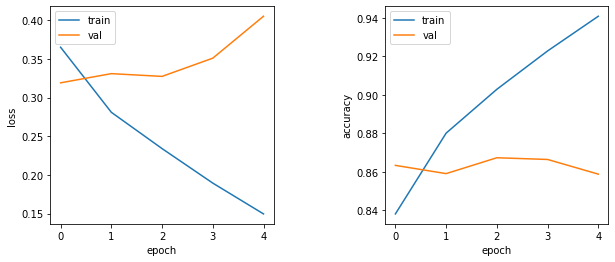

In [20]:
# Mecab 적용시 history
show_history(history_bymecab)

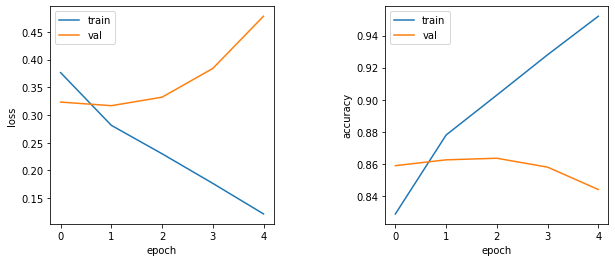

In [21]:
# SeptencePiece 적용 history
show_history(history_bysp)

In [22]:
print('Test Result (Mecab 적용) :', results_mecap)
print('Test Result (SeptencePiece 적용) :', results_sp)

Test Result (Mecab 적용) : [0.40137678384780884, 0.8595927357673645]
Test Result (SeptencePiece 적용) : [0.4832207262516022, 0.8396159410476685]


**Mecab 과 SentencePiece를 적용해 구축한 말뭉치로 학습한 결과가 비슷하게 나왔다.** 
- 학습시와 정확도는 Mecab 모델은 85%, SentencePiece 모델은 84%정도로 근소하게  Mecab 모델 높았으며 테스트시에도 약간 성능이 좋게 나왔다. 하지만 다국어에 쓰이는 SentencePiece 모델로 이런 성능이 나왔다는것이 놀랍다.

- SentencePiece의 경우 따로 불용어 처리를 해줄 필요가 없고, word_to_index, index_to_word 사전을 설정하기위한 코드도 추가하지 않고 함수호출로 참고가 가능하여 편리했다.

---
실제 영화 리뷰 문장을 넣어 감정분석이 잘되는지 테스트해보자.

In [23]:
def review_predict_bymecab(review_sentence):
    review_list = []

    # Mecab를 활용한 sentence -> encoding
    # 텍스트 스트링(리뷰문장)을 word_to_index을 참고하여 인덱스 리스트로 구성
    def wordlist_to_indexlist(wordlist):
        return [word_to_index_mc[word] if word in word_to_index_mc else word_to_index_mc['<UNK>'] for word in wordlist]

    index_review = list(map(wordlist_to_indexlist, review_sentence))
    review_list.append(index_review)
    pad_new = pad_sequences(review_list, padding='pre', maxlen = max_len) # 패딩

    score = float(model_bymecab.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [24]:
def review_predict_bysp(review_sentence):
    review_list = []

    s = spm.SentencePieceProcessor()
    s.Load('movie_review.model')

    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = s.EncodeAsIds(review_sentence)
    review_list.append(tokensIDs)
    pad_new = pad_sequences(review_list, padding='pre', maxlen = max_len) # 패딩

    score = float(model_bysp.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [34]:
review_predict_bymecab('너무 기다렸던 영화라 완전 기대하고 봤는데... 별로')

96.02% 확률로 부정 리뷰입니다.



In [33]:
review_predict_bysp('너무 기다렸던 영화라 완전 기대하고 봤는데... 별로')

99.93% 확률로 부정 리뷰입니다.



In [27]:
review_predict_bymecab('티니핑들이 캐치될때 표정이 특히 웃긴다!!') #막내 feat

50.14% 확률로 부정 리뷰입니다.



In [28]:
review_predict_bysp('티니핑들이 캐치될때 표정이 특히 웃긴다!!') #막내 feat

97.41% 확률로 긍정 리뷰입니다.



In [29]:
review_predict_bymecab('인생역전, 예측이 안되는 반전!') 

84.30% 확률로 긍정 리뷰입니다.



In [30]:
review_predict_bysp('인생역전, 예측이 안되는 반전!') 

92.27% 확률로 긍정 리뷰입니다.



실제 영화문장을 넣었을때 분류 성능은 SentencePiece가 좋아보인다. 
- 1번문장의 경우 긍정의 말이 많은 문장에 마지막에 <별로> 라는 단어가 들어가 있는데 두 모델 모두 부정으로 잘맞추었지만 부정리뷰의 확률이 SentencePiece쪽이 아주 높게 나왔다.
- 2번문장의 경우 최근 나온 새로운 단어들(막내가 시청하는 TV캐릭터)를 넣어봤는데 긍정리뷰임에도 Mecab은 잘못된 판단을 내리고있고 SentencePiece 높은 확률로 긍정으로 분석했다. 계속적으로 변화는 자연어의 특성상 이런 새로운 단어들이 계속 생기는데 SentencePiece 모델은 이런부분을 유연하게 잘처리하고 있다.
- 3번 문장의 경우 긍정리뷰의 확률이 SentencePiece쪽이 높게 나왔다.

## 4) SentencePiece 모델의 model_type, vocab_size 등을 변경

마지막으로 model_type을 변경하여 성능을 비교해보겠다.
- model_type : unigram -> bpe


In [35]:
train_data, test_data = read_review_data()
X_train, y_train, X_test, y_test = load_data(train_data, test_data, vocab_size, 'bpe')

model_bysp2, history_bysp2 = train(X_train, y_train)

train_data: (150000, 3) test_data: (50000, 3)
Epoch 1/5
3655/3655 [==============================] - 37s 10ms/step - loss: 0.3765 - accuracy: 0.8289 - val_loss: 0.3245 - val_accuracy: 0.8599
Epoch 2/5
3655/3655 [==============================] - 33s 9ms/step - loss: 0.2805 - accuracy: 0.8794 - val_loss: 0.3156 - val_accuracy: 0.8666
Epoch 3/5
3655/3655 [==============================] - 33s 9ms/step - loss: 0.2292 - accuracy: 0.9037 - val_loss: 0.3294 - val_accuracy: 0.8651
Epoch 4/5
3655/3655 [==============================] - 33s 9ms/step - loss: 0.1746 - accuracy: 0.9280 - val_loss: 0.3653 - val_accuracy: 0.8568
Epoch 5/5
3655/3655 [==============================] - 41s 11ms/step - loss: 0.1227 - accuracy: 0.9523 - val_loss: 0.4460 - val_accuracy: 0.8526


In [36]:
results_sp2 = model_bysp2.evaluate(X_test,  y_test, verbose=2)
print(results_sp2)


1537/1537 - 5s - loss: 0.4577 - accuracy: 0.8486 - 5s/epoch - 3ms/step
[0.45766517519950867, 0.848587155342102]


In [38]:
print(results_sp) #unigram

[0.4832207262516022, 0.8396159410476685]


model type이 bpe인 경우 unigram일때보다 1%가량 정확도가 상승하였다.

- vocab_size : 10000 -> 15000

In [39]:
vocab_size = 15000
train_data, test_data = read_review_data()
X_train, y_train, X_test, y_test = load_data(train_data, test_data, vocab_size,  'bpe')

model_bysp3, history_bysp3 = train(X_train, y_train)

train_data: (150000, 3) test_data: (50000, 3)
Epoch 1/5
3655/3655 [==============================] - 36s 10ms/step - loss: 0.3760 - accuracy: 0.8301 - val_loss: 0.3181 - val_accuracy: 0.8633
Epoch 2/5
3655/3655 [==============================] - 36s 10ms/step - loss: 0.2641 - accuracy: 0.8880 - val_loss: 0.3139 - val_accuracy: 0.8671
Epoch 3/5
3655/3655 [==============================] - 35s 9ms/step - loss: 0.2022 - accuracy: 0.9165 - val_loss: 0.3459 - val_accuracy: 0.8640
Epoch 4/5
3655/3655 [==============================] - 35s 10ms/step - loss: 0.1376 - accuracy: 0.9457 - val_loss: 0.4339 - val_accuracy: 0.8594
Epoch 5/5
3655/3655 [==============================] - 37s 10ms/step - loss: 0.0811 - accuracy: 0.9700 - val_loss: 0.5311 - val_accuracy: 0.8514


In [40]:
results_sp3 = model_bysp3.evaluate(X_test,  y_test, verbose=2)
print(results_sp3)

1537/1537 - 5s - loss: 0.5439 - accuracy: 0.8468 - 5s/epoch - 3ms/step
[0.5439363121986389, 0.8468376994132996]


vocab_size를 1만개에서 1만5000개로 늘려보았는데 성능이 변화가 없었다. 추후에 실험을 통해 좋은 성능 나오는 vocab_size를 구해보는 것도 좋을 것같다.

Reference
--- 
- [bpe-sentencepiece](http://tensorboy.com/bpe-sentencepiece)
- [Sentencepiece python module example](https://colab.research.google.com/github/google/sentencepiece/blob/master/python/sentencepiece_python_module_example.ipynb)